In [1]:
import pandas as pd
import numpy as np
from os.path import join as oj
import datatable as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#If the session its loaded with the pkl file its not neccesary to run code until "Feature importance and correlations" section
#This is highly recommended because the code gets 4 hours aprox to run.
import dill
filename = 'stat154_hw2.pkl'
#dill.dump_session(filename)
#dill.load_session(filename)

### Data Loading and visualization

Load the data we are using to predict minimum annual temperature and average cloud density. 

In [2]:
snp_orig_dt = dt.fread(oj("869_NoCal_CR0.99.tagSNPs_BigLD0.70.txt"))

In [3]:
df = snp_orig_dt.to_pandas()

In [4]:
df.head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A,...,Chr19_15910732_A,Chr19_15918565_C,Chr19_15918732_T,Chr19_15919416_T,Chr19_15924615_G,Chr19_15924814_G,Chr19_15927152_C,Chr19_15931754_C,Chr19_15934532_G,Chr19_15937702_C
0,BESC-418,BESC-418,False,False,False,-9,1.0,2.0,2.0,2.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,1.0,2.0
1,BESC-52,BESC-52,False,False,False,-9,2.0,1.0,2.0,2.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
2,BESC-79,BESC-79,False,False,False,-9,2.0,1.0,NaN,2.0,...,2,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0
3,BESC-246,BESC-246,False,False,False,-9,NaN,NaN,2.0,2.0,...,2,2.0,NaN,2,2.0,0.0,2.0,2.0,2.0,2.0
4,BESC-313,BESC-313,False,False,False,-9,2.0,1.0,2.0,1.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0


Load the data we are trying to predict.

In [5]:
cloud_dens_orig = pd.read_csv("cloud_dens_yearAvg", sep="\t", header=None)
tmin_orig = pd.read_csv("tmin_yearAvg", sep="\t", header=None)

In [6]:
cloud_dens_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.693175
1,BESC-52,BESC-52,-0.025059
2,BESC-79,BESC-79,0.151925
3,BESC-246,BESC-246,-0.929824
4,BESC-313,BESC-313,-0.689698


In [7]:
tmin_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.377185
1,BESC-52,BESC-52,0.391660
2,BESC-79,BESC-79,0.490293
3,BESC-246,BESC-246,0.080623
4,BESC-313,BESC-313,0.467125


### EDA

First we have to check if we have the same length for X and Y.  Also its important to know that the FID its in the same order in the three dataframes.

In [8]:
tmin_orig[0].equals(cloud_dens_orig[0])

True

In [9]:
tmin_orig[0].equals(df["FID"])

True

With that cleared, we now focus on the integrity of the response data.

In [10]:
tmin_orig.isna().sum()

0     0
1     0
2    82
dtype: int64

In [11]:
tmin_orig.isna().sum()[2] / tmin_orig.shape[0] 

0.09436133486766399

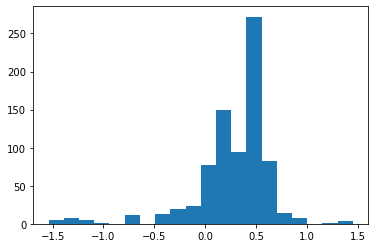

In [12]:
plt.hist(tmin_orig[2], bins=20);

We have 82 missing values of 869. This corresponds to 9.4% of our data. Also we know that the distribution of it its the bimodal type. Because of this we think that the correct thing to do is to drop the NAs.

Now lets check the cloud density dataframe.

In [13]:
cloud_dens_orig.isna().sum()

0    0
1    0
2    0
dtype: int64

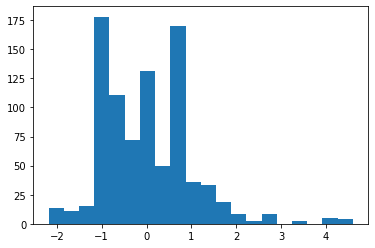

In [14]:
plt.hist(cloud_dens_orig[2], bins=20);

For this dataframe we are not missing values.

Now lets check the dataframe that we are going to use for predicting the variables above.

In [15]:
df.isna().sum().describe()

count    786075.000000
mean          1.650722
std           2.205017
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           8.000000
dtype: float64

In [16]:
df.isna().sum()[df.isna().sum() > 0].shape[0]

423219

In [17]:
df.isna().sum().sum()

1297591

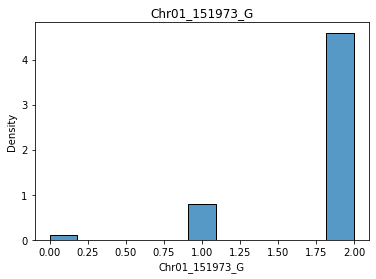

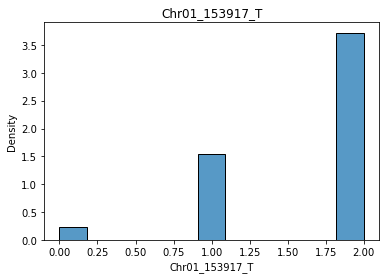

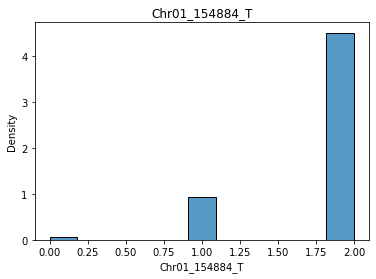

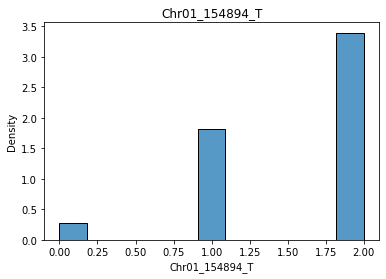

In [18]:
sample = df.iloc[:,100:104]
for i in sample:
    sns.histplot(df[i],stat = 'density')
    plt.title(i)
    plt.show()

We have 423219 columns with missing values out of 786075. This corresponds to 53% of our columns. Also we have 1297591 Nans spread in our 869 rows, so we cannot drop the nas. Also looking at the distribution of some variables we prefer to get rid of the nans later in the modeling with some smart imputation.

### Modeling and evaluation

First we need to set our X and Ys. As mentioned before, we are droping the Nas of the temperature dataframe. So we are going to drop this exact same rows for the dataframe we are using to predict temperature.

Working with all the dataframe takes a lot of computational resources and time. So for this homework we are taking a random sample of 10,000 columns of the dataframe. We also did some regressions with complete dataframe, but for this part of the code we are only using the sample. The results with the full dataframe are showed later.

In [19]:
### WE USE THE X DATAFRAME ONLY USING THE GENOMAS ###
X1 = df.drop(columns=["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"]).sample(n=10000, axis=1)
Y1 = tmin_orig[2]
X2 = df.drop(columns=["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"]).sample(n=10000, axis=1)
Y2 = cloud_dens_orig[2]
### DROP THE NANS FOR THE TEMPERATURE PREDICTION ###
X1 = X1[~Y1.isna()]
Y1 = Y1[~Y1.isna()]

Our X1 and Y1 are the dataframes for the temperature regression and the X2 Y2 are for the cloud dataframe regression.

In [20]:
X1.shape, Y1.shape

((787, 10000), (787,))

In [21]:
X2.shape, Y2.shape

((869, 10000), (869,))

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
# note: the following does NOT do a 60-20-20% train-valid-test split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2)
X1_train, X1_valid, Y1_train, Y1_valid = train_test_split(X1_train, Y1_train, test_size=0.2)
# note: the following does NOT do a 60-20-20% train-valid-test split
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2)
X2_train, X2_valid, Y2_train, Y2_valid = train_test_split(X2_train, Y2_train, test_size=0.2)

In [24]:
X1_train.shape, Y1_train.shape, X1_valid.shape, Y1_valid.shape, X1_test.shape, Y1_test.shape

((503, 10000), (503,), (126, 10000), (126,), (158, 10000), (158,))

In [25]:
X2_train.shape, Y2_train.shape, X2_valid.shape, Y2_valid.shape, X2_test.shape, Y2_test.shape

((556, 10000), (556,), (139, 10000), (139,), (174, 10000), (174,))

We think that the best the best strategy for clearing the nans is with KNN Imputer.
KNN Imputer produces a more accurate estimate of missing values than using a single correlated feature because it is based upon correlations with all other features and not just one. Alternatively, if a feature with missing values has no correlates and knn doesn’t provide any useful information as to the missing values, averaging the nearest neighbor feature values should approximate the feature mean. KNN Imputer therefore imputes a more accurate estimate of missing values without requiring as much investigation into the source of missing values.

Also we are using classic random forest to predict the data.

Prediction on temperature dataset.

In [26]:
# imputer = SimpleImputer(strategy="most_frequent")
# imputer = IterativeImputer(max_iter=10, random_state=0)
imputer = KNNImputer()
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe.fit(X1_train, Y1_train)

Pipeline(steps=[('impute', KNNImputer()), ('rf', RandomForestRegressor())])

In [27]:
Y1pred_valid = pipe.predict(X1_valid)
mean_squared_error(Y1_valid, Y1pred_valid)

0.09116106247678601

In [28]:
r2_score(Y1_valid, Y1pred_valid)

0.19931815081162585

Prediction on cloud dataset

In [29]:
# imputer = SimpleImputer(strategy="most_frequent")
# imputer = IterativeImputer(max_iter=10, random_state=0)
imputer = KNNImputer()
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe.fit(X2_train, Y2_train)

Pipeline(steps=[('impute', KNNImputer()), ('rf', RandomForestRegressor())])

In [30]:
Y2pred_valid = pipe.predict(X2_valid)
mean_squared_error(Y2_valid, Y2pred_valid)

0.7653579230010018

In [31]:
r2_score(Y2_valid, Y2pred_valid)

0.32110483606481477

Trying different methos on both datasets.

In [32]:
imputers = {
    #"simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer(),
    #"iterative_imputer": IterativeImputer(max_iter=10, random_state=0)
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso(),
    "ridge": Ridge()
}

pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe

In [33]:
### Temperature dataset
valid_errs1 = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X1_train, Y1_train)
    valid_errs1[pipe_name] = pipe.score(X1_valid, Y1_valid)
valid_errs1

knn_imputer+rf
knn_imputer+lasso
knn_imputer+ridge


{'knn_imputer+rf': 0.26245849759607864,
 'knn_imputer+lasso': -0.028615927206122826,
 'knn_imputer+ridge': 0.5278744806454239}

In [34]:
### Cloud dataset
valid_errs2 = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X2_train, Y2_train)
    valid_errs2[pipe_name] = pipe.score(X2_valid, Y2_valid)
valid_errs2

knn_imputer+rf
knn_imputer+lasso
knn_imputer+ridge


{'knn_imputer+rf': 0.29798881561808277,
 'knn_imputer+lasso': -0.0019706261896381694,
 'knn_imputer+ridge': 0.6742356300729035}

Now adding CV parameters

In [37]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "ridge__alpha": np.logspace(-2, 2, 10),
    # can also tune parameters in the imputation step
    "knn_imputer__n_neighbors": [2, 5, 10]
}

In [42]:
### Temperature dataset
valid_errs1 = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search = GridSearchCV(pipe, cv_param_grid, cv=5)
    pipe_search.fit(X1_train, Y1_train)
    valid_errs1[pipe_name] = pipe_search.score(X1_valid, Y1_valid)
print(pipe_search.best_params_)
valid_errs1

knn_imputer+rf
knn_imputer+lasso
knn_imputer+ridge
{'knn_imputer__n_neighbors': 2, 'ridge__alpha': 0.01}


{'knn_imputer+rf': 0.25791902036819214,
 'knn_imputer+lasso': 0.34355156001460807,
 'knn_imputer+ridge': 0.5276151196699128}

In [43]:
### Cloud dataset
valid_errs2 = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search = GridSearchCV(pipe, cv_param_grid, cv=5)
    pipe_search.fit(X2_train, Y2_train)
    valid_errs2[pipe_name] = pipe_search.score(X2_valid, Y2_valid)
print(pipe_search.best_params_)
valid_errs2

knn_imputer+rf
knn_imputer+lasso
knn_imputer+ridge
{'knn_imputer__n_neighbors': 5, 'ridge__alpha': 0.01}


{'knn_imputer+rf': 0.32467726013342724,
 'knn_imputer+lasso': 0.4616729218894631,
 'knn_imputer+ridge': 0.6742773702448335}

### Feature importance and correlations.

##### Most important features to predict temperature

In [58]:
#Random Forest
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor(n_estimators=100, min_samples_leaf=5))])
pipe.fit(X1_train, Y1_train)

Pipeline(steps=[('impute', KNNImputer()),
                ('rf', RandomForestRegressor(min_samples_leaf=5))])

In [59]:
rf_1 =pd.DataFrame(pipe.steps[1][1].feature_importances_,np.array(X1_train.columns)).sort_values(by=0,ascending=False)
#rf_1

,0
Chr06_11447730_G,0.065463
Chr16_709033_G,0.040447
Chr04_21338770_T,0.016512
Chr16_947544_C,0.015751
Chr10_7947361_C,0.012245
...,...
Chr04_3176589_A,0.000000
Chr14_12379622_C,0.000000
Chr06_11977218_T,0.000000
Chr19_11913491_C,0.000000


In [60]:
#Ridge
pipe = Pipeline(steps=[("impute", imputer), ("Ridge", Ridge(alpha=0.01))])
pipe.fit(X1_train, Y1_train)

Pipeline(steps=[('impute', KNNImputer()), ('Ridge', Ridge(alpha=0.01))])

In [61]:
ridge_1 = abs(pd.DataFrame(pipe.steps[1][1].coef_,np.array(X1_train.columns))).sort_values(by=0,ascending=False)
#ridge_1

,0
Chr08_12983336_G,6.006072e-03
Chr03_10364265_A,5.662037e-03
Chr03_15164631_A,5.620078e-03
Chr13_3115456_A,5.619347e-03
Chr12_12929924_G,5.465610e-03
...,...
Chr08_9230205_A,8.192630e-07
Chr16_13896160_C,7.989365e-07
Chr14_6954948_T,3.111341e-07
Chr18_11957996_C,2.952834e-07


In [74]:
#Lasso
pipe = Pipeline(steps=[("impute", imputer), ("lasso", Lasso(alpha=0.01))])
pipe.fit(X1_train, Y1_train)

Pipeline(steps=[('impute', KNNImputer()), ('lasso', Lasso(alpha=0.01))])

In [75]:
lasso_1 = abs(pd.DataFrame(pipe.steps[1][1].coef_,np.array(X1_train.columns))).sort_values(by=0,ascending=False)
#lasso_1

,0
Chr08_10952890_T,0.044195
Chr03_15164631_A,0.042685
Chr16_13511066_G,0.041210
Chr03_12607472_A,0.040670
Chr04_21338770_T,0.037899
...,...
Chr17_13942050_A,0.000000
Chr13_12241330_A,0.000000
Chr18_12730352_T,0.000000
Chr19_1525495_C,0.000000


##### Most important features to predict cloud density

In [64]:
#Random Forest
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor(n_estimators=100, min_samples_leaf=5))])
pipe.fit(X2_train, Y2_train)

Pipeline(steps=[('impute', KNNImputer()),
                ('rf', RandomForestRegressor(min_samples_leaf=5))])

In [65]:
rf_2 =pd.DataFrame(pipe.steps[1][1].feature_importances_,np.array(X2_train.columns)).sort_values(by=0,ascending=False)
#rf_2

,0
Chr08_3419315_C,0.018286
Chr06_18427323_T,0.015218
Chr16_3031940_G,0.014684
Chr05_5545458_C,0.014530
Chr09_7205804_T,0.011175
...,...
Chr04_18040408_C,0.000000
Chr10_19332904_C,0.000000
Chr14_13529239_G,0.000000
Chr01_16707127_C,0.000000


In [66]:
#Ridge
pipe = Pipeline(steps=[("impute", imputer), ("Ridge", Ridge(alpha=0.01))])
pipe.fit(X2_train, Y2_train)

Pipeline(steps=[('impute', KNNImputer()), ('Ridge', Ridge(alpha=0.01))])

In [67]:
ridge_2 = abs(pd.DataFrame(pipe.steps[1][1].coef_,np.array(X2_train.columns))).sort_values(by=0,ascending=False)
#ridge_2

,0
Chr04_18522628_T,1.445907e-02
Chr10_19373844_C,1.364123e-02
Chr09_7089458_A,1.361398e-02
Chr03_17471649_A,1.346790e-02
Chr05_5253394_A,1.339824e-02
...,...
Chr12_5888474_A,1.121814e-06
Chr18_15916107_T,1.052789e-06
Chr10_9282863_G,8.276009e-07
Chr03_12467275_T,6.579250e-07


In [68]:
#Lasso
pipe = Pipeline(steps=[("impute", imputer), ("lasso", Lasso(alpha=0.01))])
pipe.fit(X2_train, Y2_train)

Pipeline(steps=[('impute', KNNImputer()), ('lasso', Lasso(alpha=0.01))])

In [69]:
lasso_2 = abs(pd.DataFrame(pipe.steps[1][1].coef_,np.array(X2_train.columns))).sort_values(by=0,ascending=False)
#lasso_2

,0
Chr03_17471649_A,0.126190
Chr12_4467079_G,0.122553
Chr16_7482389_A,0.113815
Chr05_5279555_C,0.113770
Chr15_11087292_C,0.101849
...,...
Chr13_13788174_T,0.000000
Chr08_10404544_C,0.000000
Chr06_16745003_T,0.000000
Chr17_13074610_G,0.000000


In [97]:
rf_1.columns = ["Importance RF1"]
rf_2.columns = ["Importance RF2"]
lasso_1.columns = ["Importance Lasso1"]
lasso_2.columns = ["Importance Lasso2"]
ridge_1.columns = ["Importance Ridge1"]
ridge_2.columns = ["Importance Ridge2"]
###
rf_1["Rank RF1"] = np.arange(10000)
rf_2["Rank RF2"] = np.arange(10000)
lasso_1["Rank Lasso1"] = np.arange(10000)
lasso_2["Rank Lasso2"] = np.arange(10000)
ridge_1["Rank Ridge1"] = np.arange(10000)
ridge_2["Rank Ridge2"] = np.arange(10000)

### We are calling the most important features in random forest the variables that explains better the tree. For Lasso and Ridge the most important features are the variables with the absolute highers coefficients. We got ranked every single feature for both regressions in every method.

###  For getting a more general idea of which chromosomes are more important, we came up with the idea of making a dataframe with the ranking of all features in all the methods and trying to find a way to search which chromosomes are the ones that represents in average the best all the methods. For this we just added the rank of every chromosome in the 3 methos and order from minimum to maximum. 

##### Final feature importance for temperature

In [120]:
feature_temp = rf_1.merge(ridge_1, left_index=True, right_index=True)
feature_temp = feature_temp.merge(lasso_1,left_index=True, right_index=True)
feature_temp['Rank'] = feature_temp['Rank RF1'] + feature_temp['Rank Ridge1'] + feature_temp['Rank Lasso1']
feature_temp = feature_temp.sort_values(by ='Rank')
feature_temp

,Importance RF1,Rank RF1,Importance Ridge1,Rank Ridge1,Importance Lasso1,Rank Lasso1,Rank
Chr07_627740_A,0.008558,10,0.004377,37,0.028051,16,63
Chr03_11253575_A,0.005454,23,0.004433,33,0.029385,15,71
Chr02_14125200_G,0.010885,7,0.003900,68,0.030265,11,86
Chr03_12607472_A,0.001551,103,0.005417,5,0.040670,3,111
Chr16_6017580_T,0.002815,50,0.004204,45,0.024520,25,120
...,...,...,...,...,...,...,...
Chr01_23075752_C,0.000000,9418,0.000032,9793,0.000000,9943,29154
Chr18_1323246_A,0.000000,9843,0.000036,9764,0.000000,9571,29178
Chr10_9103249_G,0.000000,9424,0.000012,9912,0.000000,9955,29291
Chr13_12925730_C,0.000000,9868,0.000016,9894,0.000000,9584,29346


In [127]:
print("For temperature, the 10 most relevant chromosomes along RF, Lasso and Ridge are: ", list(feature_temp.head(10).index))

For temperature, the 10 most relevant chromosomes along RF, Lasso and Ridge are:  ['Chr07_627740_A', 'Chr03_11253575_A', 'Chr02_14125200_G', 'Chr03_12607472_A', 'Chr16_6017580_T', 'Chr19_11545928_T', 'Chr07_12519179_A', 'Chr12_12929924_G', 'Chr18_3963411_T', 'Chr11_5939315_G']


##### Final feature importance for cloud density

In [121]:
feature_cloud = rf_2.merge(ridge_2, left_index=True, right_index=True)
feature_cloud = feature_cloud.merge(lasso_2,left_index=True, right_index=True)
feature_cloud['Rank'] = feature_cloud['Rank RF2'] + feature_cloud['Rank Ridge2'] + feature_cloud['Rank Lasso2']
feature_cloud = feature_cloud.sort_values(by ='Rank')
feature_cloud

,Importance RF2,Rank RF2,Importance Ridge2,Rank Ridge2,Importance Lasso2,Rank Lasso2,Rank
Chr16_7482389_A,0.005591,14,0.011179,25,0.113815,2,41
Chr14_15182127_G,0.010133,6,0.010678,32,0.098602,5,43
Chr15_7187539_C,0.007727,11,0.011789,20,0.073763,16,47
Chr15_11087292_C,0.004515,19,0.010745,29,0.101849,4,52
Chr18_4556782_A,0.008101,9,0.010934,28,0.057741,35,72
...,...,...,...,...,...,...,...
Chr02_13299754_G,0.000000,9804,0.000006,9980,0.000000,8760,28544
Chr10_19332904_C,0.000000,9996,0.000035,9905,0.000000,8663,28564
Chr03_18130615_C,0.000000,9970,0.000015,9956,0.000000,8646,28572
Chr18_15916107_T,0.000000,9954,0.000001,9996,0.000000,8629,28579


In [128]:
print("For cloud density, the 10 most relevant chromosomes along RF, Lasso and Ridge are: ", list(feature_cloud.head(10).index))

For cloud density, the 10 most relevant chromosomes along RF, Lasso and Ridge are:  ['Chr16_7482389_A', 'Chr14_15182127_G', 'Chr15_7187539_C', 'Chr15_11087292_C', 'Chr18_4556782_A', 'Chr05_5545458_C', 'Chr03_17471649_A', 'Chr08_3419315_C', 'Chr03_19290799_T', 'Chr10_16538027_G']


#### Correlation Heatmaps between this variables

<AxesSubplot:>

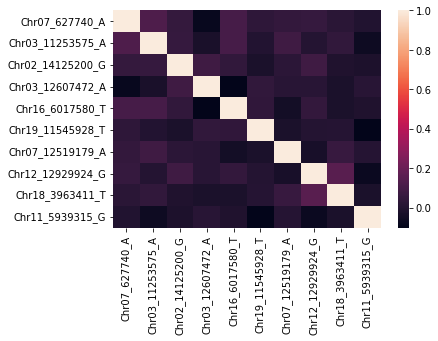

In [138]:
sns.heatmap(X1_train[list(feature_temp.head(10).index)].corr())

<AxesSubplot:>

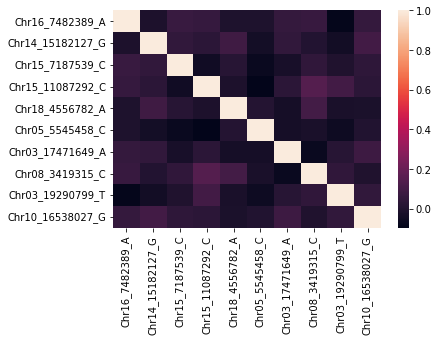

In [139]:
sns.heatmap(X2_train[list(feature_cloud.head(10).index)].corr())

# Short explanation and additional resources

For this project we got a huge database with a lot of chromosomes and with this we are trying to predict temperature and cloud density. We separated the big dataframe with the chromosomes into two, X1 and X2, also we made two arrays with the values that we are trying to predict, Y1 and Y2 (temperature and cloud density respectively). X1 and Y1 corresponds to Temperature prediction and X2 and Y2 corresponds to Cloud density prediction. 

Its important to mark a few things. First the dataframe was huge, running just random forest with the whole dataframe tooked a lot of time, so we decided to get a sample of 10,000 columns of the dataframe. Also its important to know that the Y1 had a bit of missing values, so we dropped this rows in the X1 dataframe. The rest of missing values are in X1 and X2, we got rid of this Nans values with KNN Imputer, above we explained our decission. After this, we separated the data into training, test, and validation for a better practice.

Then we got the results which are very interesting. Ridge regression with an alpha of 0.01 and 5 folds was our best model. We expected this because since we are working with a chromosomes/genes database we cannot just eliminate the value of somes variables like Lasso does, Ridge tries to give all the variables some importance. 

Finally we wanted to take a look to the chromosomes that have more importance in both regressions. For this, we used the feature importance function that random forest already has, and also the coefficients for ridge and lasso. Doing a type of "average" we got the chromosomes that were more consistent in the three models, after that we looked at the correlation between this.

Members of the team:

-Luis Leopoldo Jimenez Perez

-Alvaro David Lopez Chavez

-Diego Paasche Portillo

-Gil Herzberg Alperon

Also credits to GSI Tiffany Tang, in this notebook we used a lot of code that we take from her walktrough.

#### Prediction using random forest with the whole dataset. (Took so much time to run)

In [141]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/y1mrMNI.jpg")